In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score,mean_squared_error
from urllib.request import urlopen
from bs4 import BeautifulSoup
from urllib.error import HTTPError
import csv
%matplotlib inline
plt.style.use('bmh')

## Web Scraping data 

In [2]:
def get_options():

    '''This function extract the year list and season list
       No input argument required
       Return 2 list reference as a tuple
    '''

    try:
        url_option = 'http://quotes.money.163.com/trade/lsjysj_zhishu_399300.html?year=2017&season=4'
    except HTTPError as e:
        print("HTTP error occured while retriving the year list")

    try:
        bsobj = BeautifulSoup(urlopen(url_option).read(),'html.parser')

        year_list = []
        season_list = []

        for option in bsobj.find_all('select',{'name':'year'})[0].find_all('option'):
            year_list.append(option.get_text())

        for option in bsobj.find_all('select',{'name':'season'})[0].find_all('option'):
            season_list.append(option.attrs['value'])
        return (year_list,season_list)
    except AttributeError as e:
        print('Attribute Error while retriving year and season list, check for website structure changes')

    return (year_list,season_list)


def spider(years = None,seasons = None):

    '''This function scrapes the target website for stock historical data
       and write the data into 'result.csv' file
       No return value
    '''
    if (years is None) and (seasons is None):
        years,seasons = get_options()

    # a get request is sent to sever which require 2 params year and season
    base_url = 'http://quotes.money.163.com/trade/lsjysj_zhishu_399300.html?year=%s&season=%s'
    f = open('sphist.csv','w')
    writer = csv.writer(f)

    header = True
    for year in years:
        for season in seasons:
            # construct a request url
            url = base_url % (year,season)
            try:
                bsobj = BeautifulSoup(urlopen(url).read(),'html.parser')
            except HTTPError as e:
                print("Error while retriving stock table data")

            try:
                if header:
                    # write the header row into csv file
                    th_list = (bsobj.find_all('table',{'class':'table_bg001 border_box limit_sale'})[0]).find_all('th')
                    writer.writerow([th.get_text() for th in th_list])
                    header = False

                # write data into csv file
                tr_list = (bsobj.find_all('table',{'class':'table_bg001 border_box limit_sale'})[0]).find_all('tr')[1:]
                for item in tr_list:
                    nodes = item.find_all('td')
                    writer.writerow([num.get_text().replace(',','') for num in nodes])


            except AttributeError as e:
                print(e)
    f.close()

In [3]:
spider()

## Data Cleaning

In [4]:
sphist = pd.read_csv('sphist.csv')
sphist.head(10)

,日期,开盘价,最高价,最低价,收盘价,涨跌额,涨跌幅(%),成交量(股),成交金额(元)
0,20180404,3873.63,3898.61,3852.50,3854.86,-7.62,-0.20,8.873061e+09,1.315931e+11
1,20180403,3850.15,3878.15,3839.93,3862.48,-24.44,-0.63,9.513737e+09,1.320499e+11
2,20180402,3897.01,3937.02,3882.89,3886.92,-11.58,-0.30,1.112427e+10,1.593561e+11
3,20180330,3893.75,3915.35,3879.21,3898.50,4.45,0.11,9.751227e+09,1.379593e+11
4,20180329,3854.59,3913.96,3794.26,3894.05,51.33,1.34,1.166291e+10,1.649968e+11
5,20180328,3865.05,3907.28,3835.88,3842.72,-70.55,-1.80,1.014949e+10,1.558490e+11
6,20180327,3927.49,3936.78,3881.87,3913.27,33.38,0.86,1.137007e+10,1.622915e+11
7,20180326,3862.69,3883.90,3829.92,3879.89,-25.04,-0.64,1.151391e+10,1.566045e+11
8,20180323,3896.74,3928.51,3834.94,3904.94,-115.41,-2.87,1.800804e+10,2.189050e+11
9,20180322,4062.07,4072.38,4003.72,4020.35,-40.70,-1.00,8.909526e+09,1.276643e+11


In [5]:
sphist = sphist.iloc[:-1]
sphist.columns = ['Date','Open','High','Low','Close','Diff','Range','Volume','Cash']
def convert_date(date_str):
    date_str = str(date_str)
    return date_str[0:4]+'-'+date_str[4:6]+'-'+date_str[6:8]
sphist['Date'] = sphist['Date'].apply(convert_date)
sphist['Date'] = pd.to_datetime(sphist['Date'])
sphist['Range'] = sphist['Range'].astype('float')
sphist['Diff'] = sphist['Diff'].astype('float')
sphist['Volume'] = (sphist['Volume'].astype('float') / 1000000).round(3)
sphist = sphist.sort_values(by = 'Date')
sphist = sphist.reset_index(drop = True)

## Feature Engineering

In [6]:
def generate_features(df,origin = "Close",ignore_head = 365):
    df = df.loc[ df['Date']>= datetime(year = 2005,month = 1, day = 4),:]
    for index,row in df.iloc[ignore_head:,:].iterrows():
        
        # Previous 5 day, 30 day, 1 year average of the target column
        df.loc[index,'feature_5_avg'] = df.loc[index - 5:index-1,origin].mean()
        df.loc[index,'feature_30_avg'] = df.loc[index - 30:index-1,origin].mean()
        df.loc[index,'feature_365_avg'] = df.loc[index - 365:index - 1,origin].mean()
        
        # averaged ratio of the past 5 day and 365 day
        df.loc[index,'feature_avg_ratio'] = df.loc[index,'feature_5_avg'] / df.loc[index,'feature_365_avg']
        
        # Previous 5 day, 365 day volume average
        df.loc[index,'feature_5_vol_avg'] = df.loc[index - 5:index-1,"Volume"].mean()    
        df.loc[index,'feature_365_vol_avg'] = df.loc[index - 365:index-1,"Volume"].mean()
        
        # averaged volume ratio of the past 5 day and 365 day
        df.loc[index,'feature_avg_vol_ratio'] = df.loc[index,'feature_5_vol_avg'] / df.loc[index,'feature_365_vol_avg']
        
        # Previous 5 day, 30 day, 1 year standard deviation of the target column
        df.loc[index,'feature_5_std'] = df.loc[index - 5:index - 1,origin].std()
        df.loc[index,'feature_30_std'] = df.loc[index - 30:index-1,origin].std()
        df.loc[index,'feature_365_std'] = df.loc[index - 365:index - 1,origin].std()
        
        # Previous 5 day, 365 day volume standard deviation
#         df.loc[index,'feature_5_vol_std'] = df.loc[index - 5:index - 1,'Volume'].std()
#         df.loc[index,'feature_365_vol_std'] = df.loc[index - 365:index - 1,'Volume'].std()
        
        # standard deviation ratio of the past 5 day and 365 day
#         df.loc[index,'feature_std_ratio'] = df.loc[index,'feature_5_std'] / df.loc[index,'feature_365_std']
        
        # standard deviation ratio of volume past 5 day and 365 day
#         df.loc[index,'feature_vol_std_ratio'] = df.loc[index,'feature_5_vol_std'] / df.loc[index,'feature_365_vol_std']
    return df

In [7]:
def train_test_split(df,shuffle = False,ratio = .2,random_state = 1):
    if shuffle == True:
        np.random.seed(random_state)
        new_index = np.random.permutation(df.index)
        df = df.loc[new_index,:]
        
    train = df.iloc[365:int((1-ratio) * df.shape[0]),:]
    test = df.iloc[int((1-ratio) * df.shape[0]):,:]
    return (train,test)

def split_by_date(df,date = '2013-01-01'):
    year,month,day = (int(i) for i in date.split('-'))  
    train = df[df['Date'] < datetime(year = year,month = month,day = day)].iloc[365:,:]
    test = df[df['Date'] >= datetime(year = year,month = month,day = day)]    
    return (train,test)

## Model Setup

In [8]:
def run_model_and_validate(data,target = 'Close',predict_start_date = '2013-01-01'):
    # generate feature columns
    sphist = generate_features(data,origin = target)
    
    # extract and print feature names
    features = [c for c in sphist.columns if c.startswith('feature')]
    print("*******************Features used*************************")
    for feature in features: print(feature)
        
    # split train and test set
    train,test = split_by_date(sphist,predict_start_date)
    
    # print infomation of train and test
    print("******************Training and testing dataset***********")
    print("Number of training points, ",train.shape)
    print("Number of test points, ",test.shape)
    print("Prediction starts at ",predict_start_date)
    
    
    # fit a model and make predictions
    model = SGDRegressor()
    model.fit(train[features],train[target])
    predictions = model.predict(test[features])
    
    # generate time_series plot for historical and predicted data
    fig = plt.figure(figsize = (18,8))
    plt.title("Stock Price Prediction")
    plt.plot(train.Date,train[target],label = 'Historical '+target ,c = 'g',alpha = .5)
    plt.plot(test.Date,test[target],label = "Actual " + target,c = 'b',alpha = .5)
    plt.plot(test.Date,predictions,label = "Predicted " + target,c = 'r',alpha = .5)
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.savefig(target+'.png',dpi = 300)
    plt.show()
    
    # evaluating error metrics   
    r2 = r2_score(test[target],predictions)
    mse = mean_squared_error(test[target],predictions)
    rmse = np.sqrt(mse)
    print("******************Error Metrics****************************")
    print(f"MSE is {mse}.\nRMSE is {rmse}.\nR2 score is {r2}")
    
    
    # generate error plot
    diff = test[target] - predictions
    fig = plt.figure(figsize = (18,6))
    plt.title("Error Plot")
    plt.xlabel("Data Point")
    plt.ylabel(target+" Error")
    plt.scatter(range(0,test.shape[0]),diff,alpha = .4)
    plt.show() 

## Predicting closing price

In [ ]:
run_model_and_validate(sphist)

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Predicting opening price

*******************Features used*************************
feature_5_avg
feature_30_avg
feature_365_avg
feature_avg_ratio
feature_5_std
feature_30_std
feature_365_std
feature_std_ratio
******************Training and testing dataset***********
Number of training points,  (2299, 17)
Number of test points,  (1218, 17)
Prediction starts at  2013-01-01


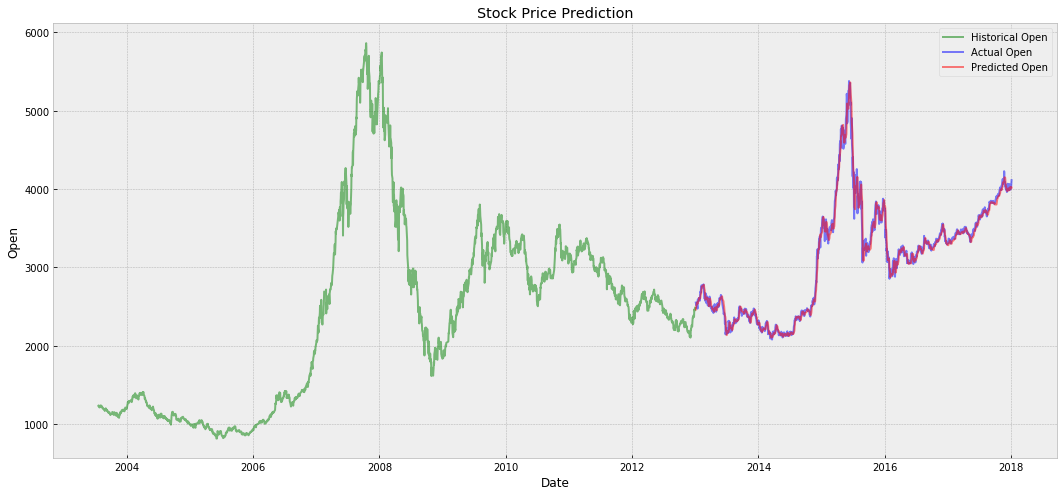

******************Error Metrics****************************
MSE is 6570.073578108594.
RMSE is 81.05599039002975.
R2 score is 0.9868909528483193


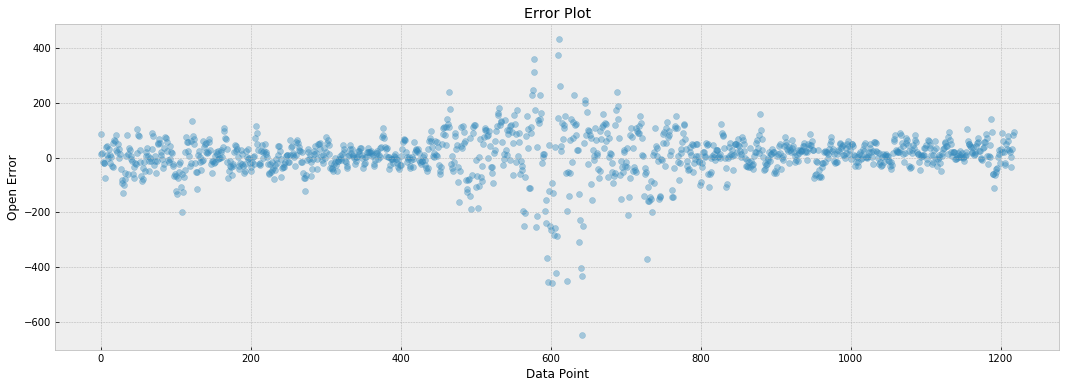

In [16]:
run_model_and_validate(sphist,target = 'Open')

## Predicting volume

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


*******************Features used*************************
feature_5_avg
feature_30_avg
feature_365_avg
feature_avg_ratio
feature_5_std
feature_30_std
feature_365_std
feature_std_ratio
******************Training and testing dataset***********
Number of training points,  (1578, 17)
Number of test points,  (1218, 17)
Prediction starts at  2013-01-01


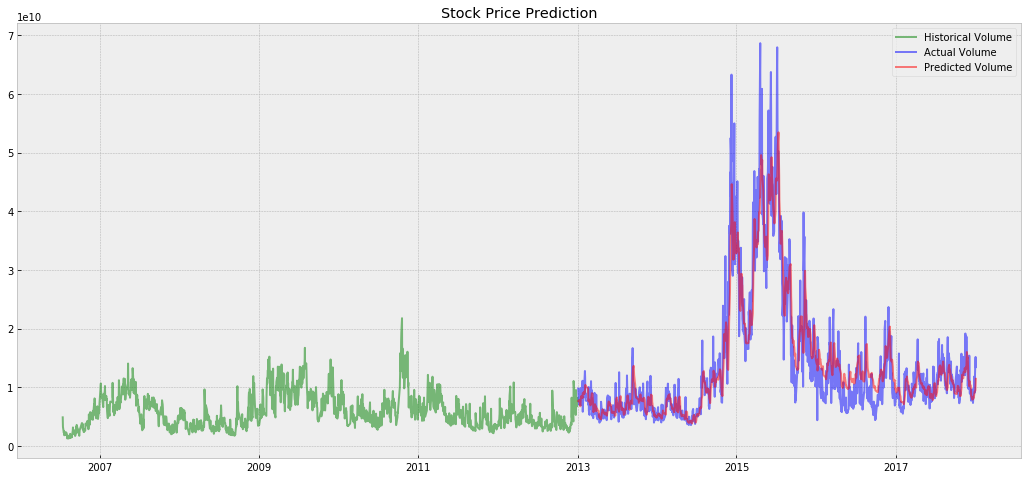

******************Error Metrics****************************
MSE is 1.8249699093995934e+19.
RMSE is 4271966654.12968.
R2 score is 0.852504967516292


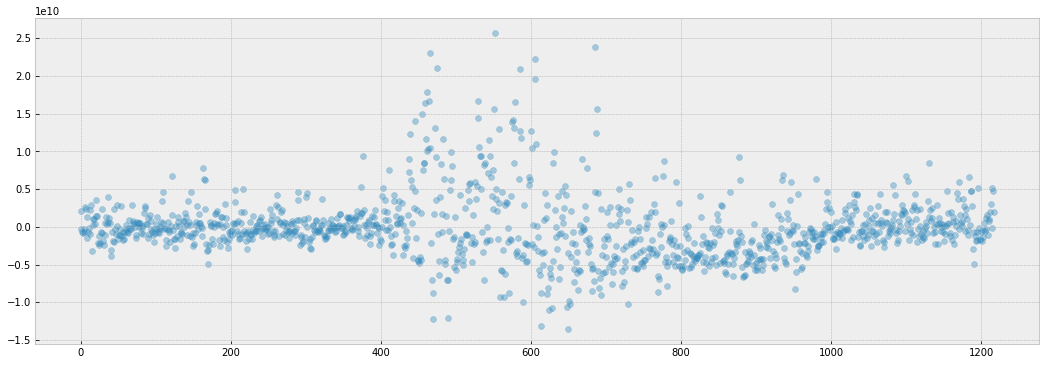

In [11]:
run_model_and_validate(volume,target = 'Volume')

NameError: name 'train' is not defined